In [226]:
import scanpy, phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scprep
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [227]:
adata_acinar = scanpy.read_h5ad('data/adata_acinar.h5ad')

In [228]:
adata_acinar.obs['clusters'] = adata_acinar.obs['clusters'].map({0: 1, 1:3, 2:2})

<Axes: title={'center': 'Acinar cells'}>

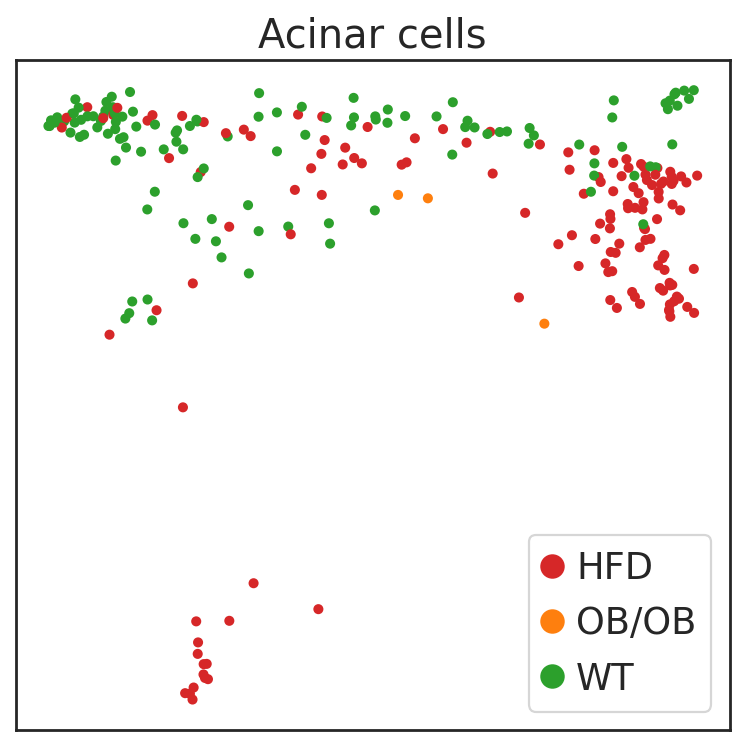

In [229]:
conversion_dict_1 = {'CG4_wt': 'WT', 'CG10_wt': 'WT', 'CG11-hfd': 'HFD', 'CG5_ob/ob': 'OB/OB'}
scprep.plot.scatter2d(adata_acinar.obsm['X_phate'], c=adata_acinar.obs['sample'].map(conversion_dict_1),
                      cmap=[plt.get_cmap("tab10")(i) for i in [3,1,2]], dpi=500, ticks=None,
                      title='Acinar cells', figsize=(5,5),
                      filename='figures/acinar_cells_by_condition.png')

<Axes: title={'center': 'Acinar cell clusters'}>

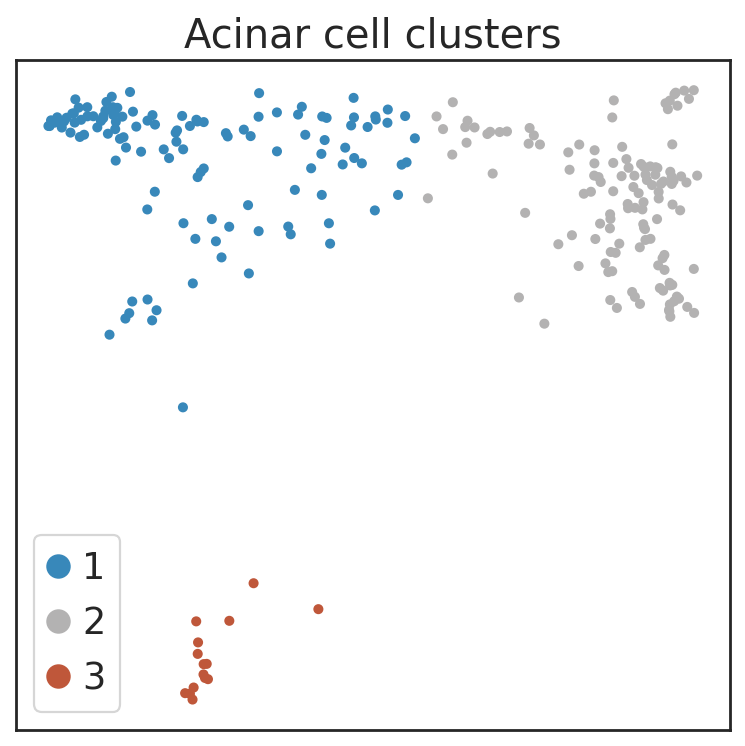

In [230]:
scprep.plot.scatter2d(adata_acinar.obsm['X_phate'],
                      c=adata_acinar.obs['clusters'],
                      ticks=None, dpi=500,
                      cmap={1:'#3888ba', 2:'#b3b2b2', 3:'#bf573a'},
                      title='Acinar cell clusters', figsize=(5,5),
                      filename='figures/acinar_cells_clusters.png')

In [231]:
adata_acinar.obs[['clusters', 'sample']].value_counts().sort_index().to_csv('results/sample_cluster_count.csv')

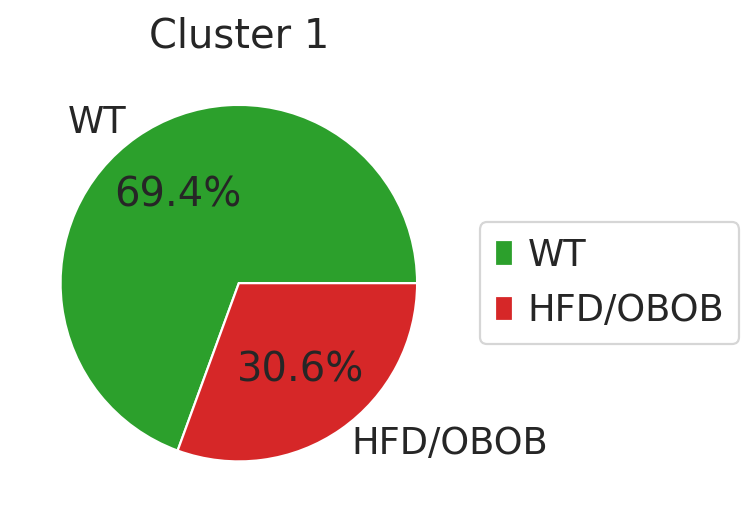

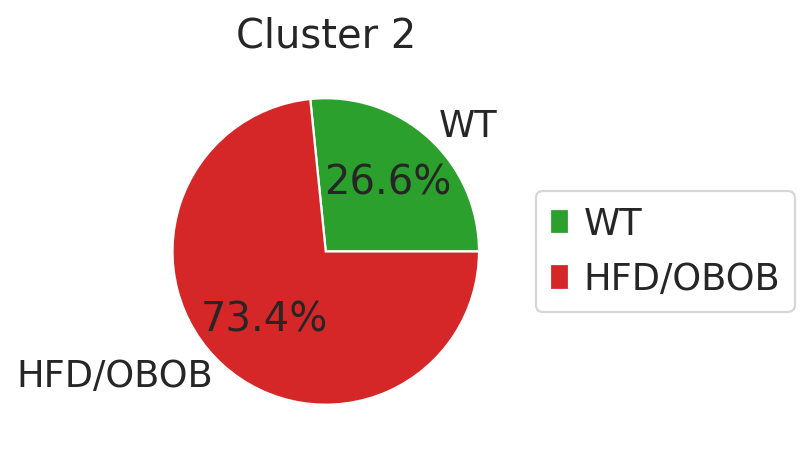

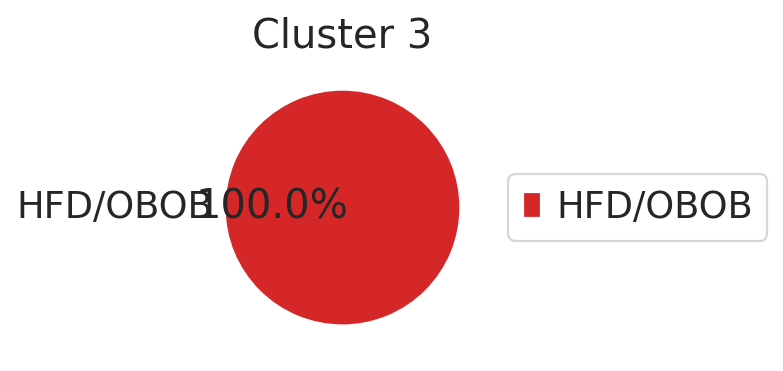

In [232]:
for cluster in [1, 2, 3]:
  fig, ax = plt.subplots(figsize=(5,5))
  val_counts = adata_acinar[adata_acinar.obs['clusters'] == cluster].obs['sample_group'].value_counts()
  val_counts = val_counts.sort_index(ascending=False)


  if val_counts.shape[0] == 1:
    colors = [plt.get_cmap("tab10")(i) for i in [3]]
  else:
    colors = [plt.get_cmap("tab10")(i) for i in [2,3]]

  pd.DataFrame(val_counts).plot.pie(y = 'count', autopct='%1.1f%%',ylabel='', colors=colors, title=f'Cluster {cluster}', ax=ax)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
  plt.tight_layout()
  fig.savefig(f'figures/acinar_cluster_{cluster}_proportion.png', dpi=300)

In [233]:
contingency_table = np.array([[adata_acinar[adata_acinar.obs['clusters'] == 1].obs['sample_group'].value_counts().loc['WT'], adata_acinar[adata_acinar.obs['clusters'] == 1].obs['sample_group'].value_counts().loc['HFD/OBOB']],
         [adata_acinar[adata_acinar.obs['clusters'] == 2].obs['sample_group'].value_counts().loc['WT'], adata_acinar[adata_acinar.obs['clusters'] == 2].obs['sample_group'].value_counts().loc['HFD/OBOB']],
         [0, adata_acinar[adata_acinar.obs['clusters'] == 3].obs['sample_group'].value_counts().loc['HFD/OBOB']]])

scipy.stats.chi2_contingency(contingency_table).pvalue

2.115193520402211e-13

In [234]:
adata_acinar.var_names_make_unique()
scanpy.pp.filter_genes(adata_acinar, min_cells=1)

In [235]:
scanpy.tl.rank_genes_groups(adata_acinar, groupby='sample_group', method='wilcoxon')
with pd.ExcelWriter(f'results/acinar_condition_differential_expression.xlsx', mode='w') as writer:
    for at in adata_acinar.obs['sample_group'].cat.categories:
        at = str(at)
        degs = pd.DataFrame([adata_acinar.var.loc[adata_acinar.uns['rank_genes_groups']['names'][at]]['names'].values,
                         adata_acinar.uns['rank_genes_groups']['logfoldchanges'][at],
                         adata_acinar.uns['rank_genes_groups']['pvals_adj'][at]]).T
        degs.columns = ['Gene symbol', 'Log FC', 'BH-adjusted p-value']
        degs.to_excel(writer, sheet_name=at.replace('/', '_'))

In [236]:
adata_acinar.var["mt"] = adata_acinar.var['names'].str.startswith("mt-")
scanpy.pp.calculate_qc_metrics(adata_acinar, qc_vars=["mt"], percent_top=None, inplace=True)

In [237]:
pd.concat((adata_acinar.obs.iloc[:, :3], adata_acinar.to_df()), axis=1).to_csv('results/acinar_cells_expr.csv')

In [238]:
acinar_markers = 'Tff2, Cel, Cpa1, Ctrl, Pnlip, Cela3b, Cpb1, Ctrb1, Try4, Try5, Try10, Reg1, Reg2, Reg3d'.split(', ')

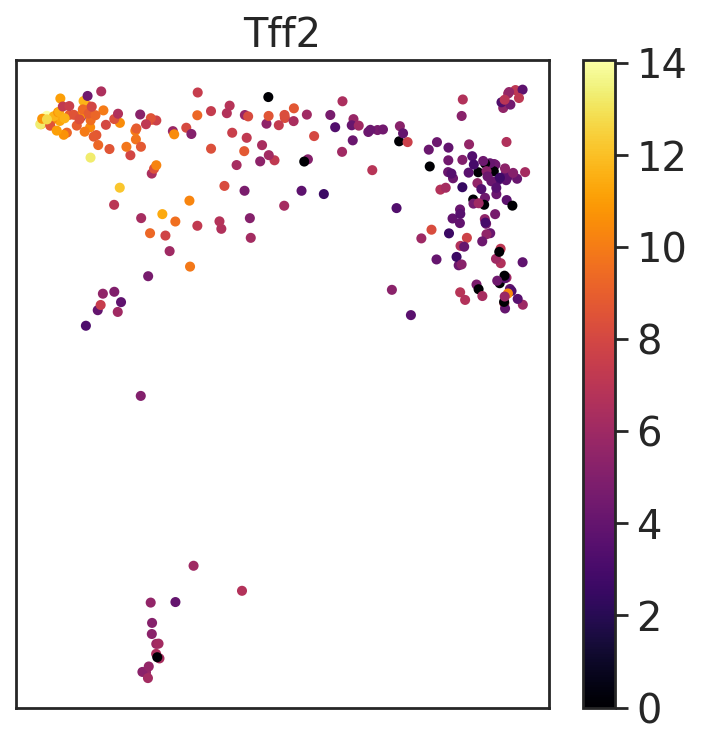

In [239]:
for gene in ['Tff2']:
  scprep.plot.scatter2d(adata_acinar.obsm['X_phate'],
                        c=adata_acinar.to_df()[gene], dpi=500,
                        ticks=None, title=gene, figsize=(5,5),
                        filename=f'figures/{gene}.png')

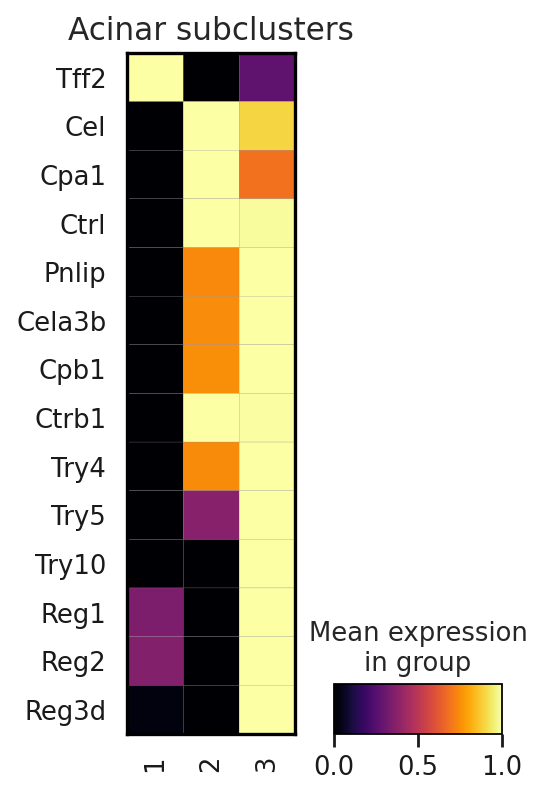

In [240]:
scanpy.set_figure_params(dpi_save=500)
scanpy.pl.matrixplot(adata_acinar,
                         var_names=acinar_markers,
                         gene_symbols='names',
                         groupby=['clusters'], categories_order=[1,2,3],
                         figsize=(3,len(acinar_markers)*0.4),
                         standard_scale='var', cmap='inferno',
                         title='Acinar subclusters',
                         swap_axes=True, save=f'acinar_marker_heatmap.png')

In [241]:
dbdb_periislet = pd.read_csv('data/GeneSetsForComparisonUpdated.csv')
dbdb_periislet_sigs = {}
for col in dbdb_periislet.columns:
  dbdb_periislet_sigs[col] = dbdb_periislet[col].dropna().values.flatten()
  dbdb_periislet_sigs[col] = np.array(list(set([x.capitalize() for x in dbdb_periislet_sigs[col]]).intersection(adata_acinar.var_names)))

In [242]:
scanpy.pp.scale(adata_acinar)

In [243]:
for key,sig in dbdb_periislet_sigs.items():
    scanpy.tl.score_genes(adata_acinar, sig, score_name=key)

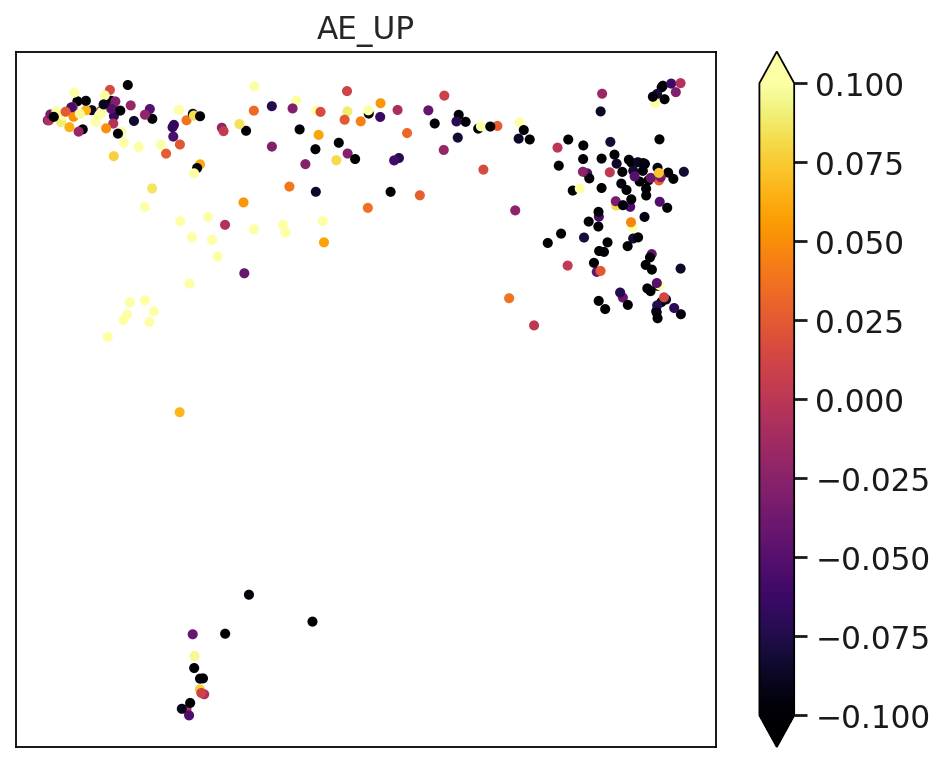

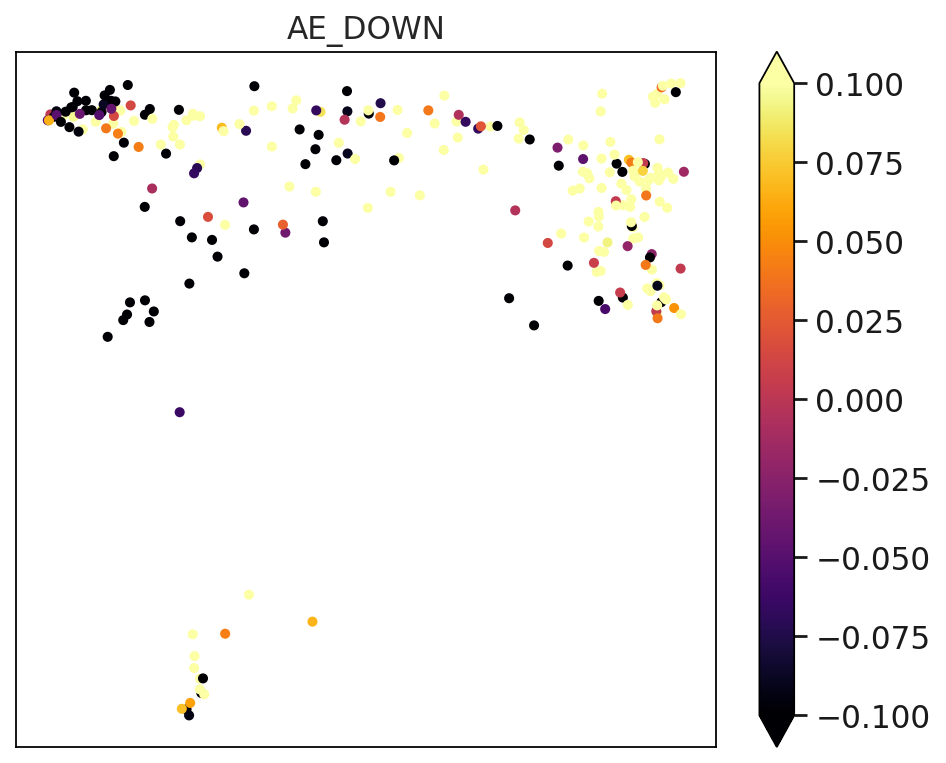

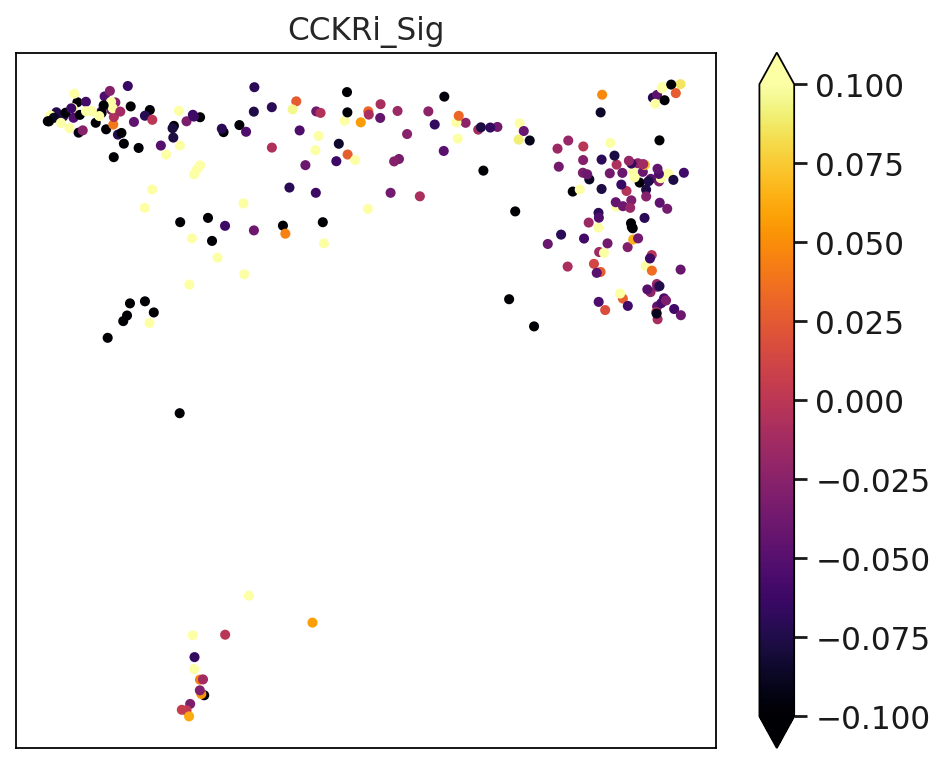

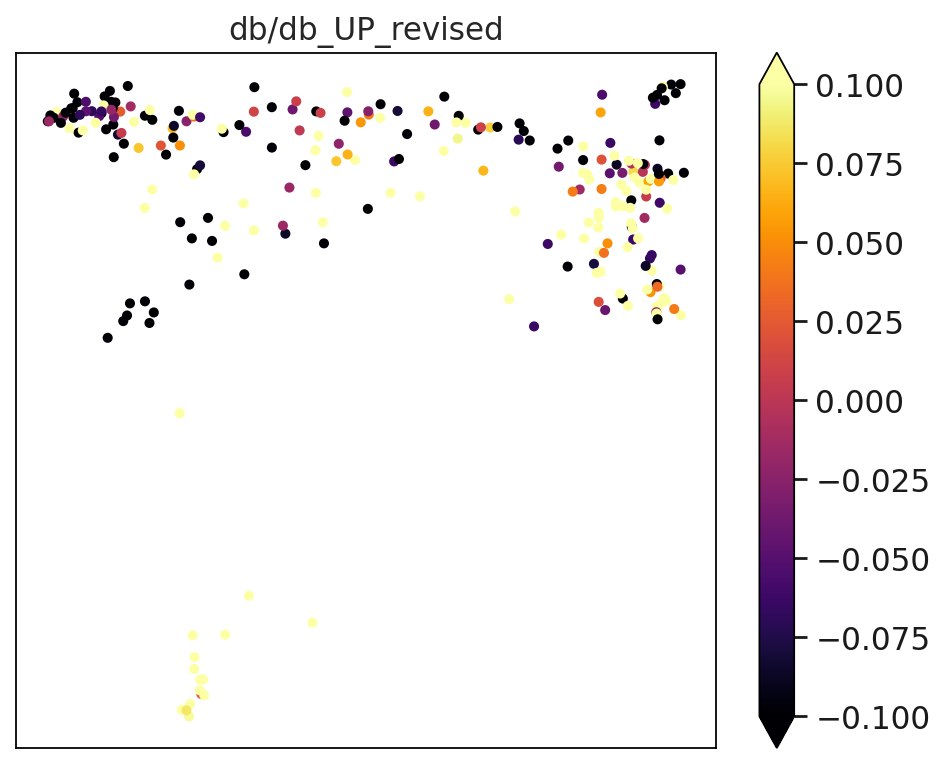

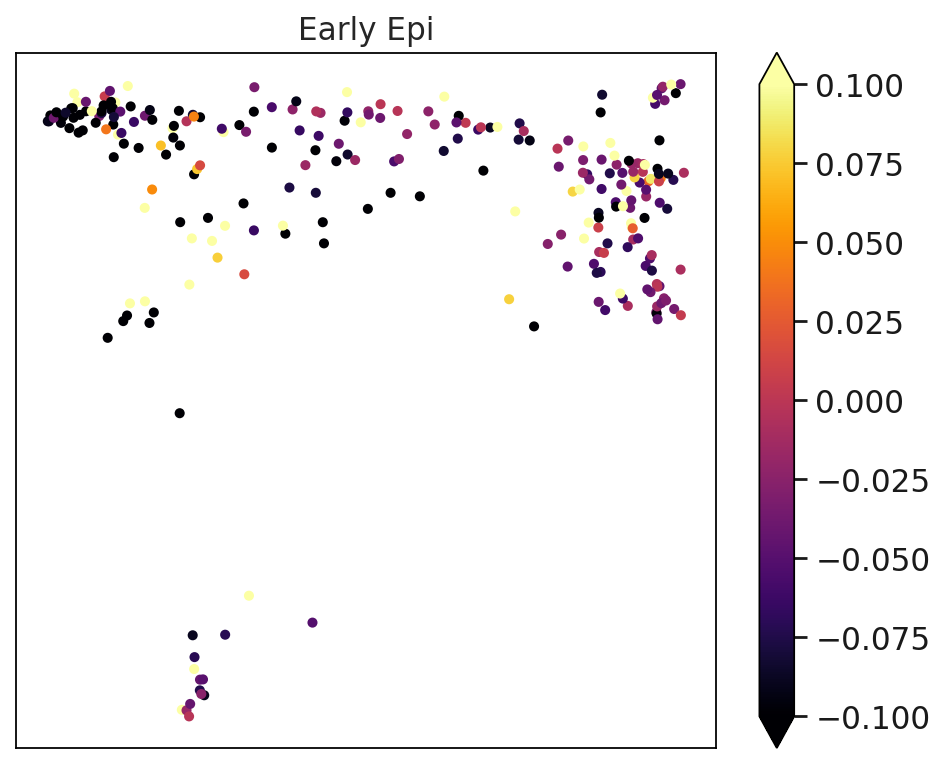

In [244]:
for gene_set in dbdb_periislet_sigs.keys():
    scprep.plot.scatter2d(adata_acinar.obsm['X_phate'], c=adata_acinar.obs[gene_set],
                      title=gene_set, cmap='inferno', figsize=(6.2, 5),
                      filename=f"figures/acinar_cells_{gene_set.replace('/', '_')}_enrichment.png",
                      vmin=-0.1, vmax=0.1,
                      ticks=None, dpi=300)

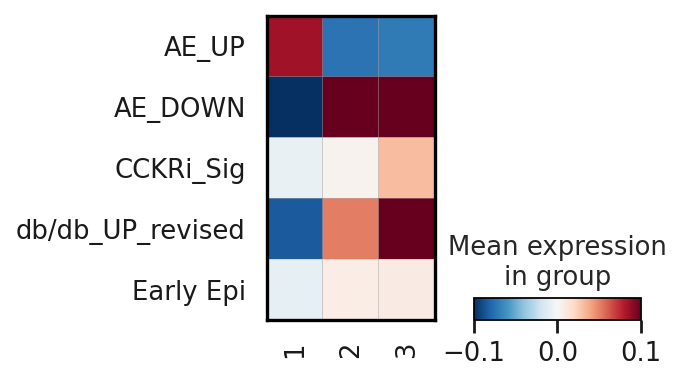

In [245]:
scanpy.set_figure_params(dpi_save=300, )
scanpy.pl.matrixplot(adata_acinar,
                         var_names=list(dbdb_periislet_sigs.keys()),
                         gene_symbols='names',
                         groupby=['clusters'], categories_order=[1,2,3],
                         figsize=(3,len(dbdb_periislet_sigs)*0.5),
                         cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                         swap_axes=True, save=f'acinar_signature_heatmap.png')

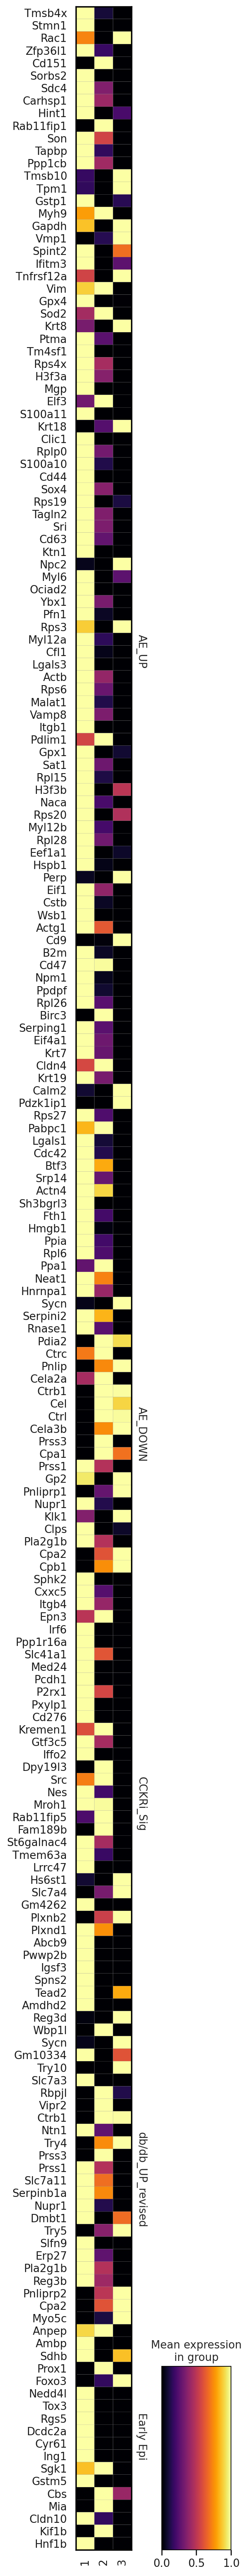

In [246]:
scanpy.set_figure_params(dpi_save=300)
scanpy.pl.matrixplot(adata_acinar,
                         var_names=dbdb_periislet_sigs,
                         gene_symbols='names',
                         groupby=['clusters'], categories_order=[1,2,3],
                         figsize=(3,len(dbdb_periislet_sigs)*10),
                         standard_scale='var', cmap='inferno',
                         swap_axes=True, save=f'acinar_signature_all_genes_heatmap.png')

In [250]:
sns.set(font_scale=1.5, style='white')

/tmp/ipykernel_2983405/1076073172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=adata_acinar.obs['sample_group'], y=adata_acinar.obs[gene_set], ax=ax, order=['WT', 'HFD/OBOB'],
/tmp/ipykernel_2983405/1076073172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=adata_acinar.obs['sample_group'], y=adata_acinar.obs[gene_set], ax=ax, order=['WT', 'HFD/OBOB'],
/tmp/ipykernel_2983405/1076073172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=adata_acinar.obs['sample_group'], y=adata_acinar.obs[gene_set], ax=ax, order=['WT', 'HFD/

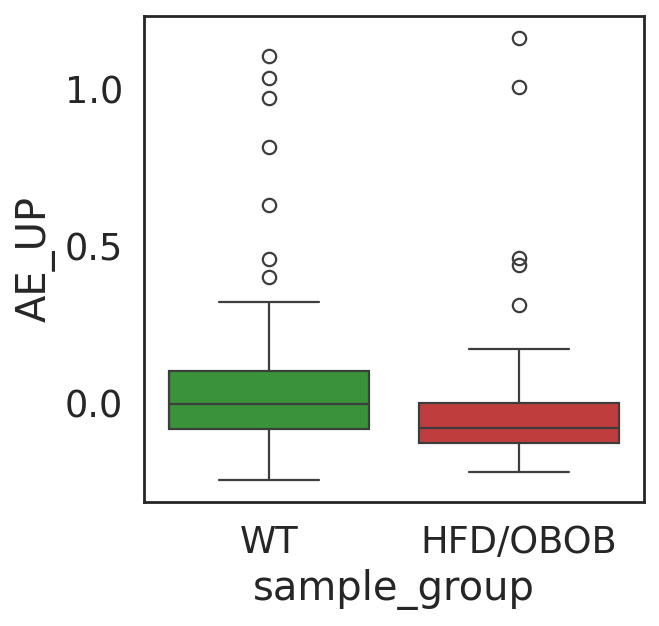

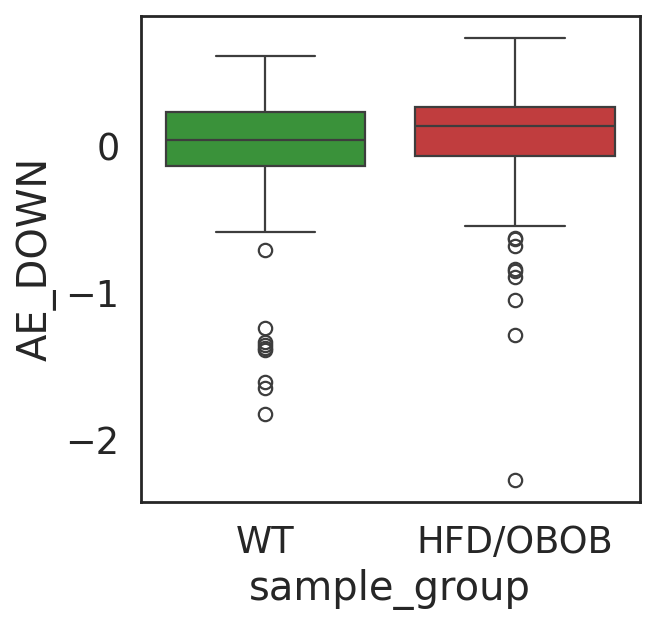

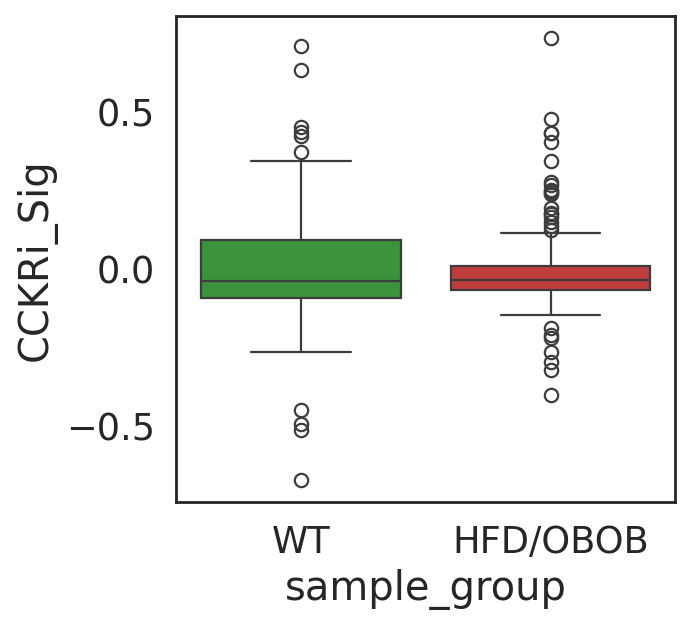

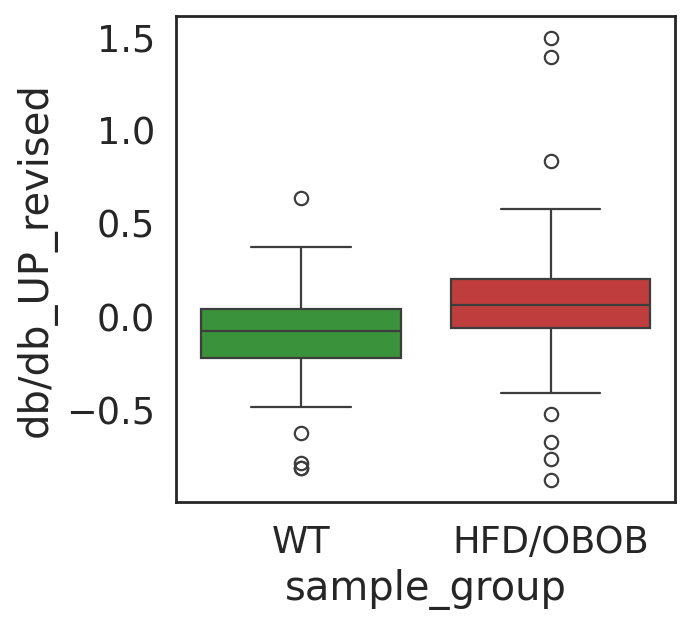

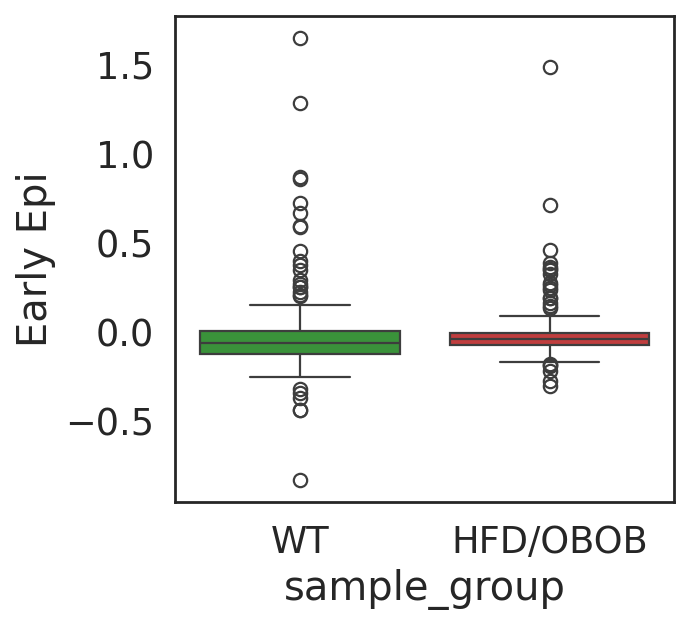

In [251]:
for gene_set in dbdb_periislet_sigs.keys():
  fig, ax = plt.subplots()
  sns.boxplot(x=adata_acinar.obs['sample_group'], y=adata_acinar.obs[gene_set], ax=ax, order=['WT', 'HFD/OBOB'],
              palette=[plt.get_cmap("tab10")(i) for i in [2,3]])
  fig.savefig(f"figures/{gene_set.replace('/', '_')}_enrichment_boxplot.png", dpi=300)

In [248]:
for gene_set in dbdb_periislet_sigs.keys():
  if gene_set == 'AE_UP':
    one_sided = 'less'
  else:
    one_sided = 'greater'
  print (gene_set, 'p =',scipy.stats.ranksums(adata_acinar.obs[gene_set][(adata_acinar.obs['sample_group'] == 'HFD/OBOB')].values,
                     adata_acinar.obs[gene_set][(adata_acinar.obs['sample_group'] == 'WT')].values,
                     alternative=one_sided).pvalue)

AE_UP p = 9.99660819063176e-07
AE_DOWN p = 0.03221597222319007
CCKRi_Sig p = 0.3518074836695776
db/db_UP_revised p = 6.728652632307261e-09
Early Epi p = 0.02450328333373559
